In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from exp.nb_Tesis import *
from PIL import ImageOps

In [2]:

from torchvision.utils import save_image


def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [4]:
model_path = Path('seg_data/images')
path_clasif_images_train = 'ISIC_2019_Training_Input/reduced-700/'
path_clasif_images_test = 'ISIC2018_Task3_Test_Input/'

In [5]:
learn = load_learner(model_path,file='square_segmenter.pkl')

In [6]:
data = ImageList.from_folder(path_clasif_images_train,recurse=False)

In [7]:
data = ImageList.from_folder(path_clasif_images_test, recurse=False)

In [9]:
data.items[0].parent

PosixPath('ISIC2018_Task3_Test_Input')

In [31]:
assert len(data) == 1512

### Ejemplo

### experiment with 4 layer imgs 

In [7]:
def tensor_to_gray(t): return t.mean(dim=0).expand(3,t.shape[1],t.shape[2])
def invert_mask(m): return (m + 1) % 2 
def visualize_mask(m): visualize_tensor(m.expand(3,m.shape[1],m.shape[2]) * 255)
def visualize_tensor(t): plt.imshow(t.permute(1, 2, 0))
def mask_color(t,mask):
    coloured_part = (t * mask)
    gray_part = invert_mask(mask) * tensor_to_gray(t)
    return coloured_part+gray_part

### New

680

In [249]:
i = 1
pred = learn.predict(data[i]); 
mask = pred[0].data

def mask_color_keep_orig_size(t,m):
    a = transforms.ToPILImage()(m*1.0)
    mask2 = transforms.ToTensor()(ImageOps.pad(a,(t.shape[2],t.shape[1])).resize((t.shape[2],t.shape[1])))
    return mask_color(t,mask2)

mask_color_keep_orig_size(data[i].data,mask)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [250]:
save_image(mask_color_keep_orig_size(data[i].data,mask),'prueba.jpg')

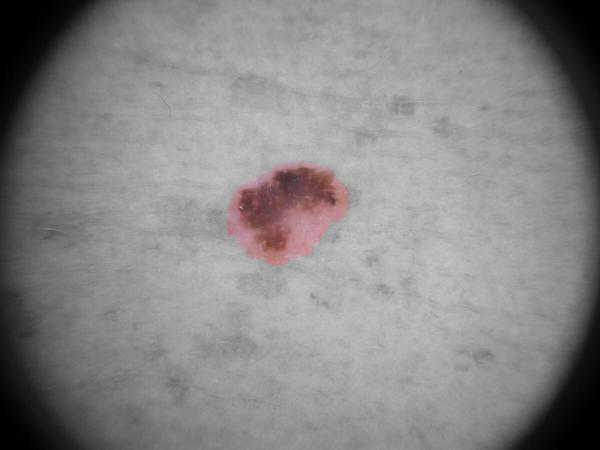

In [251]:
open_image('prueba.jpg')

### OLD

/home/mike/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


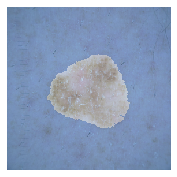

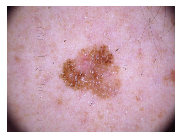

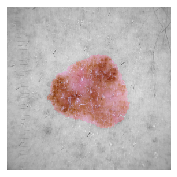

In [12]:
i = 0
pred = learn.predict(data[i]); 
mask = pred[0].data

tfmd_img = data[i].apply_tfms([crop_pad()], size=(284,284), resize_method=ResizeMethod.CROP);

tfmd_img.show(y=pred[0]); 
data[i].show(); 
pred[0].show()
visualize_tensor(mask_color(tfmd_img.data,mask))

In [14]:
save_image(mask_color(tfmd_img.data,mask), 'masked.jpg')

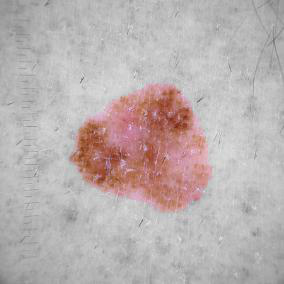

In [15]:
open_image('masked.jpg')

## Procesar todo

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [35]:
path_segmented_clasif_images_folder = Path('segmented_images_as_284/')
path_segmented_clasif_images_folder.mkdir()
n_of_images = len(data) 

In [37]:
for idx, an_image_to_segment in enumerate(data):
    filename = data.items[idx]
    filepath = filename.parent / path_segmented_clasif_images_folder / filename.name
    if not (filepath.exists()): 
        pred = learn.predict(an_image_to_segment)
        mask = pred[0].data
        tfmd_img = an_image_to_segment.apply_tfms([crop_pad()], size=(284,284), resize_method=ResizeMethod.CROP);
        save_image(mask_color(tfmd_img.data,mask), filepath)
    update_progress(idx / n_of_images)

Progress: [####################] 100.0%


In [101]:
x(path_segmented_clasif_images_folder / data.items[0]).exists()

False

In [11]:
AUROC??